# Label Images

In [1]:
import tensorflow as tf
import tensorflow_hub as hub

import requests
from PIL import Image
from io import BytesIO

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

## Helper functions

Following [this example](https://colab.research.google.com/github/AdityaKane2001/regnety/blob/main/RegNetY_models_in_TF_2_5.ipynb#scrollTo=70oBDm26mkw3)

In [2]:
#@title Helper functions for loading image (hidden)

original_image_cache = {}

def preprocess_image(image):
  image = np.array(image)
  # reshape into shape [batch_size, height, width, num_channels]
  img_reshaped = tf.reshape(image, [1, image.shape[0], image.shape[1], image.shape[2]])
  # Use `convert_image_dtype` to convert to floats in the [0,1] range.
  image = tf.image.convert_image_dtype(img_reshaped, tf.float32)
  return image

def load_image_from_path(path):
  """Returns an image with shape [1, height, width, num_channels]."""
  image = Image.open(path)
  image = preprocess_image(image)
  return image

def load_image(image_url, image_size=256, dynamic_size=False, max_dynamic_size=512):
  """Loads and preprocesses images."""
  # Cache image file locally.
  if image_url in original_image_cache:
    img = original_image_cache[image_url]
  elif image_url.startswith('https://'):
    img = load_image_from_path(image_url)
  else:
    fd = tf.io.gfile.GFile(image_url, 'rb')
    img = preprocess_image(Image.open(fd))
  original_image_cache[image_url] = img
  # Load and convert to float32 numpy array, add batch dimension, and normalize to range [0, 1].
  img_raw = img
  if tf.reduce_max(img) > 1.0:
    img = img / 255.
  if len(img.shape) == 3:
    img = tf.stack([img, img, img], axis=-1)
  if not dynamic_size:
    img = tf.image.resize_with_pad(img, image_size, image_size)
  elif img.shape[1] > max_dynamic_size or img.shape[2] > max_dynamic_size:
    img = tf.image.resize_with_pad(img, max_dynamic_size, max_dynamic_size)
  return img

def show_image(image, title=''):
  image_size = image.shape[1]
  w = (image_size * 6) // 320
  plt.figure(figsize=(w, w))
  plt.imshow(image[0], aspect='equal')
  plt.axis('off')
  plt.title(title)
  plt.show()

## Many image classification models to try.

In [3]:
#@title Select an Image Classification model

image_size = 224
dynamic_size = False

model_name = "resnet_v2_152" # @param ['efficientnetv2-s', 'efficientnetv2-m', 'efficientnetv2-l', 'efficientnetv2-s-21k', 'efficientnetv2-m-21k', 'efficientnetv2-l-21k', 'efficientnetv2-xl-21k', 'efficientnetv2-b0-21k', 'efficientnetv2-b1-21k', 'efficientnetv2-b2-21k', 'efficientnetv2-b3-21k', 'efficientnetv2-s-21k-ft1k', 'efficientnetv2-m-21k-ft1k', 'efficientnetv2-l-21k-ft1k', 'efficientnetv2-xl-21k-ft1k', 'efficientnetv2-b0-21k-ft1k', 'efficientnetv2-b1-21k-ft1k', 'efficientnetv2-b2-21k-ft1k', 'efficientnetv2-b3-21k-ft1k', 'efficientnetv2-b0', 'efficientnetv2-b1', 'efficientnetv2-b2', 'efficientnetv2-b3', 'efficientnet_b0', 'efficientnet_b1', 'efficientnet_b2', 'efficientnet_b3', 'efficientnet_b4', 'efficientnet_b5', 'efficientnet_b6', 'efficientnet_b7', 'bit_s-r50x1', 'inception_v3', 'inception_resnet_v2', 'resnet_v1_50', 'resnet_v1_101', 'resnet_v1_152', 'resnet_v2_50', 'resnet_v2_101', 'resnet_v2_152', 'nasnet_large', 'nasnet_mobile', 'pnasnet_large', 'mobilenet_v2_100_224', 'mobilenet_v2_130_224', 'mobilenet_v2_140_224', 'mobilenet_v3_small_100_224', 'mobilenet_v3_small_075_224', 'mobilenet_v3_large_100_224', 'mobilenet_v3_large_075_224']

model_handle_map = {
  "efficientnetv2-s": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_s/classification/2",
  "efficientnetv2-m": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_m/classification/2",
  "efficientnetv2-l": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_l/classification/2",
  "efficientnetv2-s-21k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_s/classification/2",
  "efficientnetv2-m-21k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_m/classification/2",
  "efficientnetv2-l-21k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_l/classification/2",
  "efficientnetv2-xl-21k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_xl/classification/2",
  "efficientnetv2-b0-21k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_b0/classification/2",
  "efficientnetv2-b1-21k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_b1/classification/2",
  "efficientnetv2-b2-21k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_b2/classification/2",
  "efficientnetv2-b3-21k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_b3/classification/2",
  "efficientnetv2-s-21k-ft1k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_ft1k_s/classification/2",
  "efficientnetv2-m-21k-ft1k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_ft1k_m/classification/2",
  "efficientnetv2-l-21k-ft1k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_ft1k_l/classification/2",
  "efficientnetv2-xl-21k-ft1k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_ft1k_xl/classification/2",
  "efficientnetv2-b0-21k-ft1k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_ft1k_b0/classification/2",
  "efficientnetv2-b1-21k-ft1k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_ft1k_b1/classification/2",
  "efficientnetv2-b2-21k-ft1k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_ft1k_b2/classification/2",
  "efficientnetv2-b3-21k-ft1k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_ft1k_b3/classification/2",
  "efficientnetv2-b0": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_b0/classification/2",
  "efficientnetv2-b1": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_b1/classification/2",
  "efficientnetv2-b2": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_b2/classification/2",
  "efficientnetv2-b3": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_b3/classification/2",
  "efficientnet_b0": "https://tfhub.dev/tensorflow/efficientnet/b0/classification/1",
  "efficientnet_b1": "https://tfhub.dev/tensorflow/efficientnet/b1/classification/1",
  "efficientnet_b2": "https://tfhub.dev/tensorflow/efficientnet/b2/classification/1",
  "efficientnet_b3": "https://tfhub.dev/tensorflow/efficientnet/b3/classification/1",
  "efficientnet_b4": "https://tfhub.dev/tensorflow/efficientnet/b4/classification/1",
  "efficientnet_b5": "https://tfhub.dev/tensorflow/efficientnet/b5/classification/1",
  "efficientnet_b6": "https://tfhub.dev/tensorflow/efficientnet/b6/classification/1",
  "efficientnet_b7": "https://tfhub.dev/tensorflow/efficientnet/b7/classification/1",
  "bit_s-r50x1": "https://tfhub.dev/google/bit/s-r50x1/ilsvrc2012_classification/1",
  "inception_v3": "https://tfhub.dev/google/imagenet/inception_v3/classification/4",
  "inception_resnet_v2": "https://tfhub.dev/google/imagenet/inception_resnet_v2/classification/4",
  "resnet_v1_50": "https://tfhub.dev/google/imagenet/resnet_v1_50/classification/4",
  "resnet_v1_101": "https://tfhub.dev/google/imagenet/resnet_v1_101/classification/4",
  "resnet_v1_152": "https://tfhub.dev/google/imagenet/resnet_v1_152/classification/4",
  "resnet_v2_50": "https://tfhub.dev/google/imagenet/resnet_v2_50/classification/4",
  "resnet_v2_101": "https://tfhub.dev/google/imagenet/resnet_v2_101/classification/4",
  "resnet_v2_152": "https://tfhub.dev/google/imagenet/resnet_v2_152/classification/4",
  "nasnet_large": "https://tfhub.dev/google/imagenet/nasnet_large/classification/4",
  "nasnet_mobile": "https://tfhub.dev/google/imagenet/nasnet_mobile/classification/4",
  "pnasnet_large": "https://tfhub.dev/google/imagenet/pnasnet_large/classification/4",
  "mobilenet_v2_100_224": "https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/classification/4",
  "mobilenet_v2_130_224": "https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4",
  "mobilenet_v2_140_224": "https://tfhub.dev/google/imagenet/mobilenet_v2_140_224/classification/4",
  "mobilenet_v3_small_100_224": "https://tfhub.dev/google/imagenet/mobilenet_v3_small_100_224/classification/5",
  "mobilenet_v3_small_075_224": "https://tfhub.dev/google/imagenet/mobilenet_v3_small_075_224/classification/5",
  "mobilenet_v3_large_100_224": "https://tfhub.dev/google/imagenet/mobilenet_v3_large_100_224/classification/5",
  "mobilenet_v3_large_075_224": "https://tfhub.dev/google/imagenet/mobilenet_v3_large_075_224/classification/5",
}

model_image_size_map = {
  "efficientnetv2-s": 384,
  "efficientnetv2-m": 480,
  "efficientnetv2-l": 480,
  "efficientnetv2-b0": 224,
  "efficientnetv2-b1": 240,
  "efficientnetv2-b2": 260,
  "efficientnetv2-b3": 300,
  "efficientnetv2-s-21k": 384,
  "efficientnetv2-m-21k": 480,
  "efficientnetv2-l-21k": 480,
  "efficientnetv2-xl-21k": 512,
  "efficientnetv2-b0-21k": 224,
  "efficientnetv2-b1-21k": 240,
  "efficientnetv2-b2-21k": 260,
  "efficientnetv2-b3-21k": 300,
  "efficientnetv2-s-21k-ft1k": 384,
  "efficientnetv2-m-21k-ft1k": 480,
  "efficientnetv2-l-21k-ft1k": 480,
  "efficientnetv2-xl-21k-ft1k": 512,
  "efficientnetv2-b0-21k-ft1k": 224,
  "efficientnetv2-b1-21k-ft1k": 240,
  "efficientnetv2-b2-21k-ft1k": 260,
  "efficientnetv2-b3-21k-ft1k": 300, 
  "efficientnet_b0": 224,
  "efficientnet_b1": 240,
  "efficientnet_b2": 260,
  "efficientnet_b3": 300,
  "efficientnet_b4": 380,
  "efficientnet_b5": 456,
  "efficientnet_b6": 528,
  "efficientnet_b7": 600,
  "inception_v3": 299,
  "inception_resnet_v2": 299,
  "mobilenet_v2_100_224": 224,
  "mobilenet_v2_130_224": 224,
  "mobilenet_v2_140_224": 224,
  "nasnet_large": 331,
  "nasnet_mobile": 224,
  "pnasnet_large": 331,
  "resnet_v1_50": 224,
  "resnet_v1_101": 224,
  "resnet_v1_152": 224,
  "resnet_v2_50": 224,
  "resnet_v2_101": 224,
  "resnet_v2_152": 224,
  "mobilenet_v3_small_100_224": 224,
  "mobilenet_v3_small_075_224": 224,
  "mobilenet_v3_large_100_224": 224,
  "mobilenet_v3_large_075_224": 224,
}

model_handle = model_handle_map[model_name]

print(f"Selected model: {model_name} : {model_handle}")


max_dynamic_size = 512
if model_name in model_image_size_map:
  image_size = model_image_size_map[model_name]
  dynamic_size = False
  print(f"Images will be converted to {image_size}x{image_size}")
else:
  dynamic_size = True
  print(f"Images will be capped to a max size of {max_dynamic_size}x{max_dynamic_size}")

labels_file = "https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt"

#download labels and creates a maps
downloaded_file = tf.keras.utils.get_file("labels.txt", origin=labels_file)

classes = []
i = 0
with open(downloaded_file) as f:
  labels = f.readlines()
  classes = [l.strip() for l in labels[1:]]
  i += 1

Selected model: resnet_v2_152 : https://tfhub.dev/google/imagenet/resnet_v2_152/classification/4
Images will be converted to 224x224


2021-10-21 21:50:38.478014: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


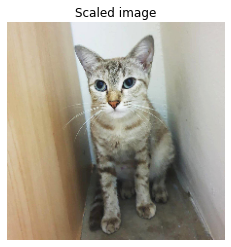

In [4]:
df = pd.read_csv("../data/train.csv")
image_path = "../data/train/" + df.Id[10] + ".jpg"
image = load_image(image_path, image_size, dynamic_size, max_dynamic_size)
show_image(image, 'Scaled image')

## Load the model and warm it up

In [5]:
classifier = hub.load(model_handle)

input_shape = image.shape
warmup_input = tf.random.uniform(input_shape, 0, 1.0)
%time warmup_logits = classifier(warmup_input).numpy()

2021-10-21 21:50:52.507538: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


CPU times: user 5.41 s, sys: 2.77 s, total: 8.18 s
Wall time: 3.11 s


CPU times: user 2.24 s, sys: 1.97 s, total: 4.21 s
Wall time: 269 ms
True
(1)  285 - Egyptian cat: 0.997462272644043
(2)  287 - lynx: 0.0010624477872624993
(3)  281 - tabby: 0.0010484869126230478
(4)  282 - tiger cat: 0.00042530856444500387
(5)  284 - Siamese cat: 4.590953608385462e-07
(6)  753 - radiator: 1.9647056603844248e-07
(7)  463 - bucket: 1.959729871714444e-07
(8)  728 - plastic bag: 9.735482109363147e-08
(9)  896 - washbasin: 6.322083834220393e-08
(10)  876 - tub: 5.43219904614034e-08


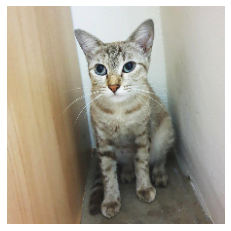

In [6]:
# Run model on image
%time probabilities = tf.nn.softmax(classifier(image)).numpy()

top_5 = tf.argsort(probabilities, axis=-1, direction="DESCENDING")[0][:10].numpy()
np_classes = np.array(classes)

# Some models include an additional 'background' class in the predictions, so
# we must account for this when reading the class labels.
includes_background_class = probabilities.shape[1] == 1001
print(includes_background_class)

for i, item in enumerate(top_5):
  class_index = item if not includes_background_class else item - 1
  line = f'({i+1}) {class_index:4} - {classes[class_index]}: {probabilities[0][top_5][i]}'
  print(line)

show_image(image, '')

In [7]:
probs = pd.read_csv("../data/checkpoint.csv")
probs[5999:6001]

,tench,goldfish,great white shark,tiger shark,hammerhead,electric ray,stingray,cock,hen,ostrich,...,buckeye,coral fungus,agaric,gyromitra,stinkhorn,earthstar,hen-of-the-woods,bolete,ear,toilet tissue
5999,9.990380e-06,0.000012,1.627915e-06,2.422505e-06,9.835518e-07,3.275185e-07,1.381498e-06,1.120071e-06,2.150049e-06,8.913369e-07,...,7.888546e-06,1.624177e-06,0.000003,6.116643e-06,1.028559e-06,5.549190e-06,2.145993e-06,7.989481e-07,3.246058e-05,0.000035
6000,4.952980e-07,0.000002,3.054867e-07,1.414156e-08,4.833180e-07,1.071856e-07,2.625173e-08,7.393962e-08,9.058562e-08,2.574579e-08,...,5.951494e-07,3.870023e-07,0.000003,1.233501e-07,1.706692e-07,3.090867e-07,2.206612e-07,3.329963e-07,7.851912e-07,0.000002


In [18]:
probs.shape

(9912, 1000)

In [19]:
snip = df[9000:9912]

In [20]:
results = np.stack(snip.apply(lambda x: tf.nn.softmax(classifier(load_image("../data/train/" + x.Id + ".jpg", image_size, dynamic_size, max_dynamic_size))).numpy()[0][-1000:].tolist(), axis=1))

In [21]:
probs[9000:9912] = results

In [22]:
probs.to_csv("../data/checkpoint.csv", index=False)

In [73]:
probs.shape

(9912, 1000)

In [74]:
reduced_set = probs[probs.columns.difference(probs.columns[pd.DataFrame(probs.max() < 0.1)[0]])]

(9912, 14)

In [73]:
test = pd.concat([df,reduced_set], axis=1)

In [74]:
test.shape

(9912, 474)

In [75]:
test.to_csv("../data/train_augmented_reduced.csv")